Practising Tensorflow dataset api and gradient tape

In [136]:
import numpy as np
import h5py as hpy
import tensorflow as tf
import sklearn.metrics as mtc
from matplotlib import pyplot as plt


In [10]:
train_File=hpy.File('train_signs.h5','r')
test_File=hpy.File('test_signs.h5','r')

x_train=tf.data.Dataset.from_tensor_slices(train_File['train_set_x'])
x_test=tf.data.Dataset.from_tensor_slices(test_File['test_set_x'])
y_train=tf.data.Dataset.from_tensor_slices(train_File['train_set_y'])
y_test=tf.data.Dataset.from_tensor_slices(test_File['test_set_y'])

In [50]:
#Normalizing data

def normalizer(image):
    image=tf.cast(image,tf.float32)/255
    image=tf.reshape(image,[-1])
    return image

new_train=x_train.map(normalizer)
new_test=x_test.map(normalizer)

In [31]:
#Reshape output labels with one-hot encoding

def one_hot_matrix(labels,depth=6):
    labels=tf.reshape(tf.one_hot(labels,depth=depth,axis=0),[-1])
    return labels

new_train_y=y_train.map(one_hot_matrix)
new_test_y=y_test.map(lambda y_test:one_hot_matrix(labels=y_test,depth=6))



In [86]:
#initialize weight and trainable parameters

def initialize_parameters(layer_dims):
    L=len(layer_dims)
    parameters={}
    trainable_parameters=[]
    initializer=tf.initializers.GlorotNormal(seed=1)
    for l in range(1,L):
        parameters['w'+str(l)]=tf.Variable(initializer(shape=(layer_dims[l],layer_dims[l-1])),name='w'+str(l))
        parameters['b'+str(l)]=tf.Variable(initializer(shape=(layer_dims[l],1)),name='b'+str(l))
        trainable_parameters.append(parameters['w'+str(l)])
        trainable_parameters.append(parameters['b'+str(l)])
    return parameters,trainable_parameters

In [168]:
#forward propagation

def forward_propagation(X,parameters):
    L=len(parameters)//2
    a_prev=tf.transpose(X)
    for l in range(1,L):
        Z=tf.math.add(tf.linalg.matmul(parameters['w'+str(l)],a_prev),parameters['b'+str(l)])
        # a_0=tf.keras.activations.relu(Z[:Z.shape[0]//2])
        # a_1=tf.keras.activations.sigmoid(Z[Z.shape[0]//2:])
        a_prev=tf.keras.activations.relu(Z)
    ZL=tf.math.add(tf.linalg.matmul(parameters['w'+str(L)],a_prev),parameters['b'+str(L)])
    return ZL


In [48]:
#compute cost function

def compute_cost(y_pred,y_true):
    cost=tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true=y_true,y_pred=tf.transpose(y_pred),from_logits=True))
    return cost

In [169]:
#model

def model(X_train,Y_train,X_test,Y_test,layer_dims,num_of_epoch=100,batch_size=32,learning_rate=0.0001):

    parameters,trainable_parameters=initialize_parameters(layer_dims)
    tfs=list(parameters.values())
    train_dataset=tf.data.Dataset.zip((X_train,Y_train))
    test_dataset=tf.data.Dataset.zip((X_test,Y_test))

    m=Y_train.cardinality().numpy()
    Adam=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    costs,train_acc,test_acc=[],[],[]

    train_accuracy=tf.metrics.CategoricalAccuracy()
    test_accuracy=tf.metrics.CategoricalAccuracy()

    for epoch in range(num_of_epoch):

        epoch_cost=0.
        train_accuracy.reset_states()
        mini_batches=train_dataset.batch(batch_size=batch_size).prefetch(8)

        for (mini_batch_X,mini_batch_Y) in mini_batches:

            with tf.GradientTape() as tape:
                ZL=forward_propagation(X=mini_batch_X,parameters=parameters)
                cost=compute_cost(y_pred=ZL,y_true=mini_batch_Y)
            
            train_accuracy.update_state(y_true=mini_batch_Y,y_pred=tf.transpose(ZL))
            grads=tape.gradient(cost,tfs)
            Adam.apply_gradients(zip(grads,tfs))
            epoch_cost+=cost
        
        epoch_cost/=m
        if epoch%10==0:
            print(f"Cost after {epoch}th is: {epoch_cost}.")
            print(f"Training accuracy after {epoch} is: {train_accuracy.result()}.")
    
    return parameters


In [171]:
parameters=model(X_train=new_train,Y_train=new_train_y,X_test=new_test,Y_test=new_test_y,layer_dims=[12288,25,12,6],num_of_epoch=350,batch_size=32,learning_rate=0.0001)


Cost after 0th is: 0.05761156231164932.
Training accuracy after 0 is: 0.17314815521240234.
Cost after 10th is: 0.049386609345674515.
Training accuracy after 10 is: 0.3611111044883728.
Cost after 20th is: 0.04329695925116539.
Training accuracy after 20 is: 0.49537035822868347.
Cost after 30th is: 0.03744129836559296.
Training accuracy after 30 is: 0.604629635810852.
Cost after 40th is: 0.03325697034597397.
Training accuracy after 40 is: 0.6527777910232544.
Cost after 50th is: 0.03032451495528221.
Training accuracy after 50 is: 0.6824073791503906.
Cost after 60th is: 0.028164686635136604.
Training accuracy after 60 is: 0.6935185194015503.
Cost after 70th is: 0.026414353400468826.
Training accuracy after 70 is: 0.7194444537162781.
Cost after 80th is: 0.02498386614024639.
Training accuracy after 80 is: 0.7333333492279053.
Cost after 90th is: 0.023723194375634193.
Training accuracy after 90 is: 0.7518518567085266.
Cost after 100th is: 0.0226153451949358.
Training accuracy after 100 is: 0.76

In [172]:
def predict(X, parameters):
    ZL=forward_propagation(X,parameters)
    AL=tf.keras.activations.softmax(tf.transpose(ZL))
    print(tf.argmax(AL,axis=1))
    return AL

mini_batch_X=new_test.batch(batch_size=new_test.cardinality())

for mini_batch in mini_batch_X:
    AL=predict(mini_batch,parameters)



tf.Tensor(
[4 0 0 5 1 0 4 1 4 1 5 1 3 1 1 3 5 5 0 4 5 4 2 5 0 5 4 4 1 5 5 1 0 3 1 1 3
 4 2 3 3 3 0 2 3 1 1 2 0 3 4 1 2 0 2 0 4 0 4 5 5 5 2 4 3 3 0 1 3 5 0 5 4 1
 3 4 3 5 1 4 2 0 1 3 1 4 4 4 4 5 5 0 0 5 5 5 3 4 5 1 2 1 0 4 5 3 0 1 3 4 1
 4 2 4 1 1 1 3 1 3], shape=(120,), dtype=int64)


In [173]:
y_hat=tf.argmax(AL,axis=1)

mini_batch_Y=new_test_y.batch(batch_size=new_test_y.cardinality())
for mini_batch in mini_batch_Y:
    y_label=tf.argmax(mini_batch,axis=1)
    
conf=tf.math.confusion_matrix(labels=y_label,predictions=y_hat,num_classes=6)
print(conf)


tf.Tensor(
[[17  0  0  2  1  0]
 [ 0 18  0  0  2  0]
 [ 0  8  9  0  2  1]
 [ 1  0  0 15  3  1]
 [ 0  0  1  2 14  3]
 [ 0  0  0  1  2 17]], shape=(6, 6), dtype=int32)


[[17  0  0  2  1  0]
 [ 0 18  0  0  2  0]
 [ 0  8  9  0  2  1]
 [ 1  0  0 15  3  1]
 [ 0  0  1  2 14  3]
 [ 0  0  0  1  2 17]]


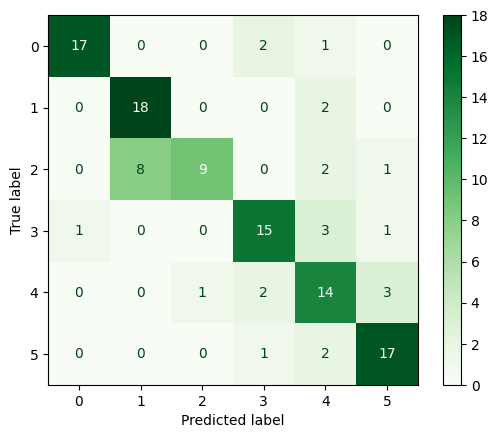

In [174]:
# mtc.confusion_matrix(y_true=y_label,y_pred=y_hat,labels=[0,1,2,3,4,5])
C=mtc.confusion_matrix(y_true=y_label,y_pred=y_hat,labels=[0,1,2,3,4,5])
print(C)
conmatrix=mtc.ConfusionMatrixDisplay(confusion_matrix=C)
conmatrix.plot(cmap='Greens')
plt.show()

Cost after 0th is: 0.05867232754826546.
Training accuracy after 0 is: 0.1666666716337204.
Cost after 10th is: 0.05622854083776474.
Training accuracy after 10 is: 0.17870371043682098.
Cost after 20th is: 0.054537583142519.
Training accuracy after 20 is: 0.32870370149612427.
Cost after 30th is: 0.05258669704198837.
Training accuracy after 30 is: 0.47592592239379883.
Cost after 40th is: 0.05111541599035263.
Training accuracy after 40 is: 0.6101852059364319.
Cost after 50th is: 0.04950283095240593.
Training accuracy after 50 is: 0.6203703880310059.
Cost after 60th is: 0.04771531745791435.
Training accuracy after 60 is: 0.6462963223457336.
Cost after 70th is: 0.04612256959080696.
Training accuracy after 70 is: 0.6851851940155029.
Cost after 80th is: 0.044562336057424545.
Training accuracy after 80 is: 0.6879629492759705.
Cost after 90th is: 0.04303167387843132.
Training accuracy after 90 is: 0.699999988079071.
Cost after 100th is: 0.041459329426288605.
Training accuracy after 100 is: 0.7203

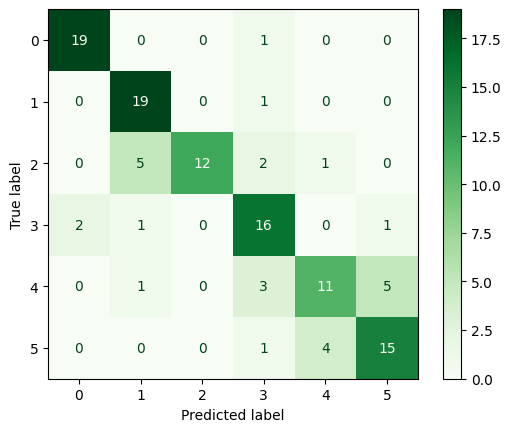

In [158]:
parameters=model(X_train=new_train,Y_train=new_train_y,X_test=new_test,Y_test=new_test_y,layer_dims=[12288,25,12,6],num_of_epoch=250,batch_size=32,learning_rate=0.0001)

mini_batch_X=new_test.batch(batch_size=new_test.cardinality())

for mini_batch in mini_batch_X:
    AL=predict(mini_batch,parameters)

y_hat=tf.argmax(AL,axis=1)

mini_batch_Y=new_test_y.batch(batch_size=new_test_y.cardinality())
for mini_batch in mini_batch_Y:
    y_label=tf.argmax(mini_batch,axis=1)

C=mtc.confusion_matrix(y_true=y_label,y_pred=y_hat,labels=[0,1,2,3,4,5])
print(C)
conmatrix=mtc.ConfusionMatrixDisplay(confusion_matrix=C)
conmatrix.plot(cmap='Greens')
plt.show()